In [1]:
print('Init')

Init


In [2]:
import torch

print(f'Cuda available: {torch.cuda.is_available()}')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Running on: {device}, Device count: {torch.cuda.device_count()}')

Cuda available: True
Running on: cuda:0, Device count: 2


### Init dataset

In [3]:
from nuscenes import NuScenes
from custom_prediction.helper import PredictHelper

In [4]:
# This is the path where you stored your copy of the nuScenes dataset.
DATAROOT = 'D:/ThesisProjects/nuScenes_dataset/'

nusc = NuScenes('v1.0-trainval', dataroot=DATAROOT, verbose=False)

In [5]:
helper = PredictHelper(nusc)

In [6]:
from nuscenes.eval.prediction.splits import get_prediction_challenge_split

train = get_prediction_challenge_split("train", dataroot=DATAROOT)
train[:5]

['4d87aaf2d82549969f1550607ef46a63_faf2ea71b30941329a3c3f3866cec714',
 '4d87aaf2d82549969f1550607ef46a63_fa3f3d82b2b94da39f67bffc4e16d5db',
 '4d87aaf2d82549969f1550607ef46a63_903f32e4fd8247de8f20aa989e157b2a',
 '4d87aaf2d82549969f1550607ef46a63_ab44d8e463d54d0ebb18eb66bbc1e5eb',
 '4d87aaf2d82549969f1550607ef46a63_cc5951ca9cb240d5a7a0738fdec37634']

#### Check one of the samples

In [38]:
instance_token, sample_token = train[4020].split("_")

TODO: Find good annotation sample for some vehicle
Look at movevent history of it
Draw car's path on BEV image

In [39]:
history_length = 2
prediction_length = 6

#### Scene visualization

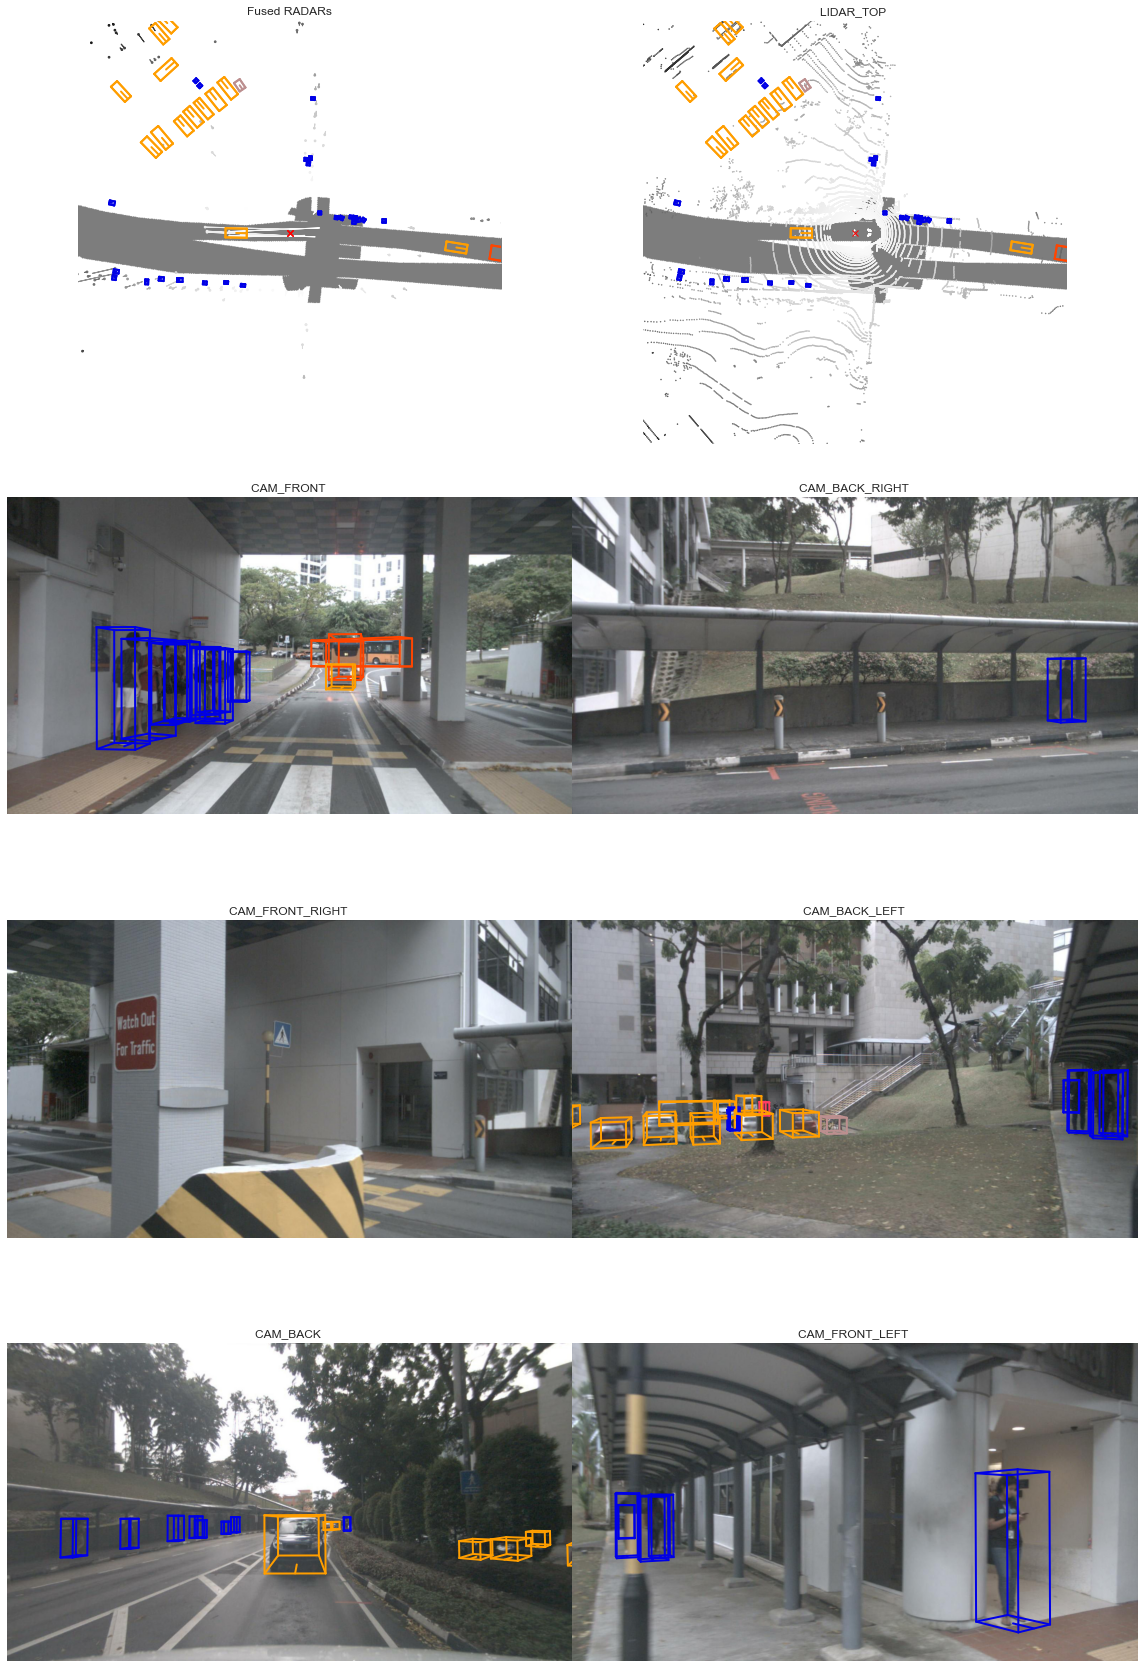

In [40]:
my_sample = nusc.get('sample', sample_token)
nusc.render_sample(sample_token)

#### Lets look at movement of agent in real world 

In [33]:
import matplotlib.pyplot as plt
import datetime

def render_future_for_agent(target_instance_token, start_prediction_sample_token, prediction_length):
    
    current_annotation = helper.get_sample_annotation(target_instance_token, start_prediction_sample_token)
    current_prediction_annotation_token = current_annotation['token']
    
    current_sample = nusc.get('sample', current_annotation['sample_token'])
    current_timestamp = current_sample['timestamp']
    
    for i in range(prediction_length * 2):
        current_sample = nusc.get('sample', current_annotation['sample_token'])
        #timestamp = datetime.datetime.fromtimestamp(current_sample['timestamp'] / 1000000.0)

        nusc.render_annotation(current_annotation['token'])
        current_annotation = nusc.get('sample_annotation', current_annotation['next'])

        plt.figure()
        img = GenerateImage(instance_token, current_annotation['sample_token'])
        plt.imshow(img)
        plt.show()

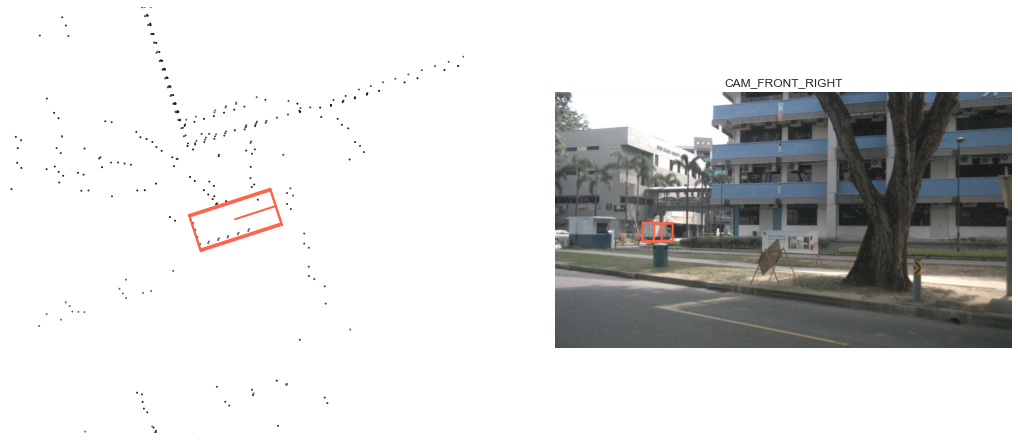

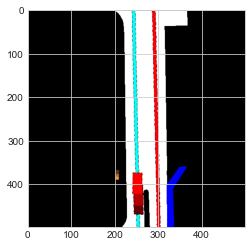

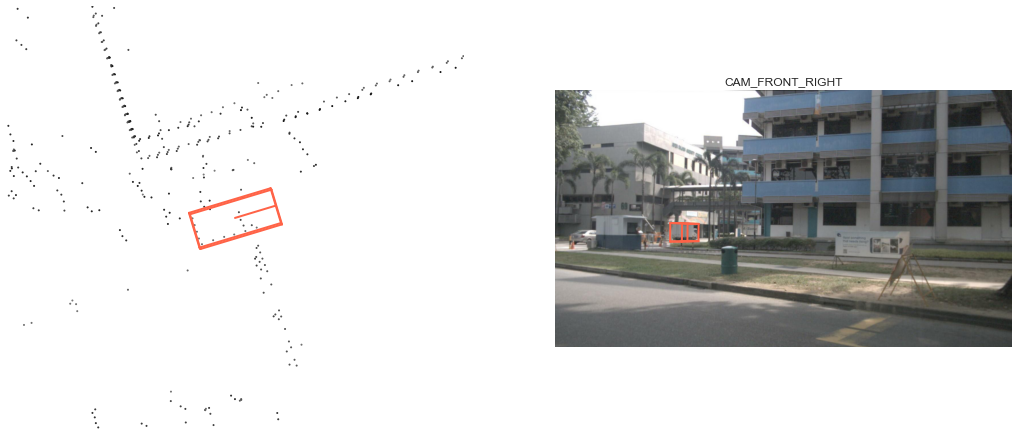

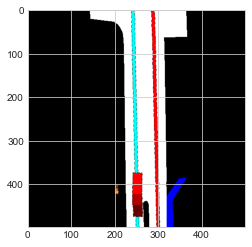

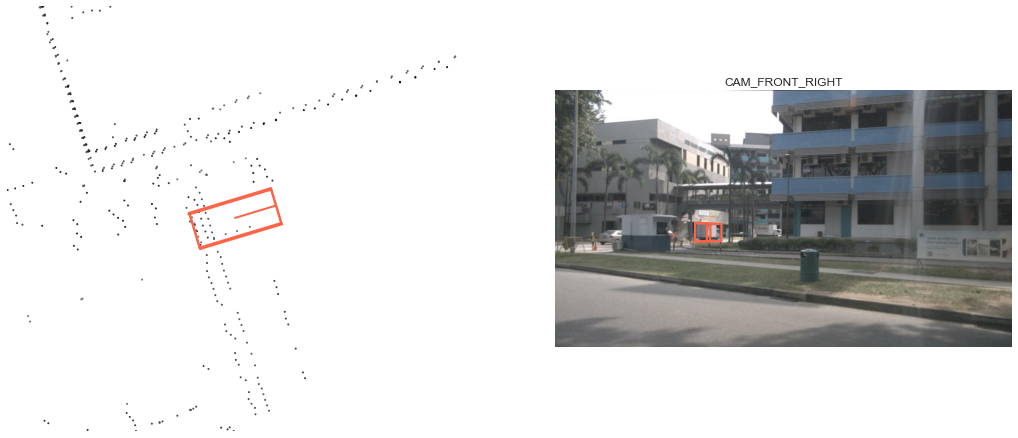

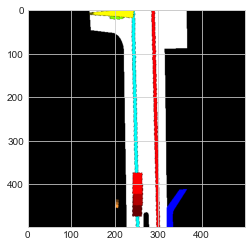

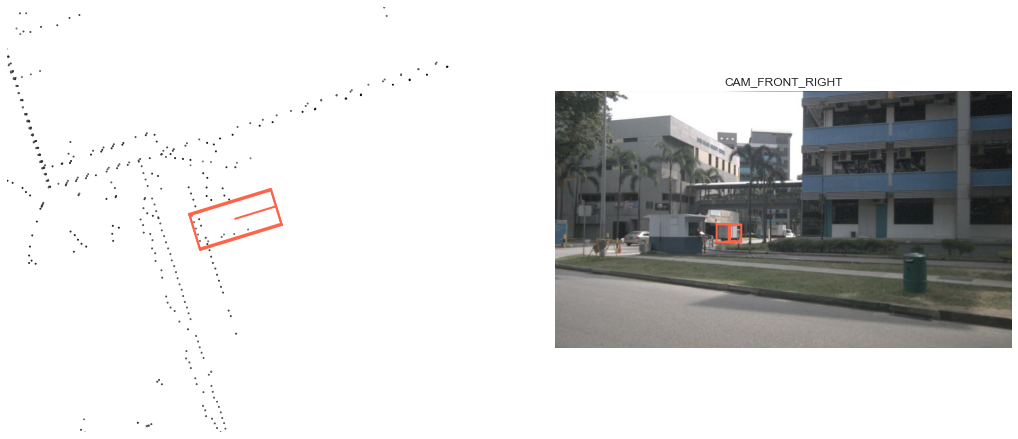

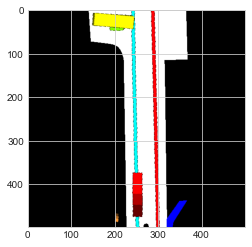

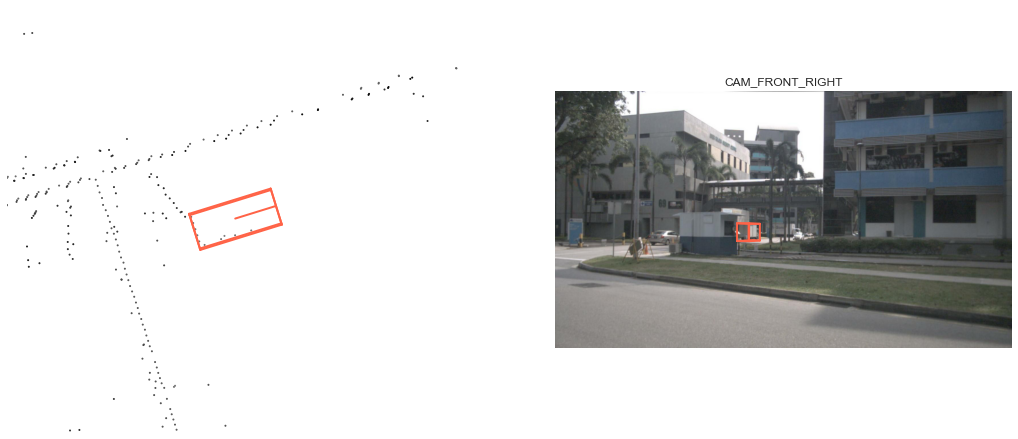

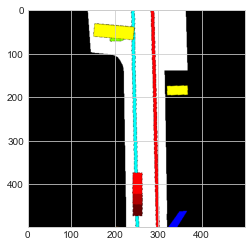

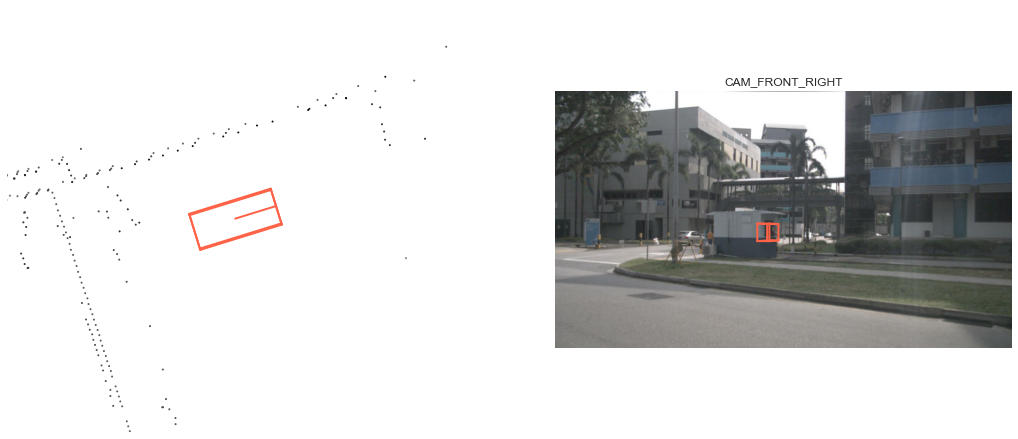

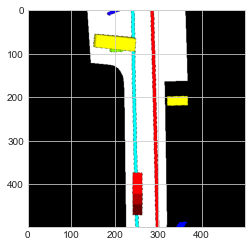

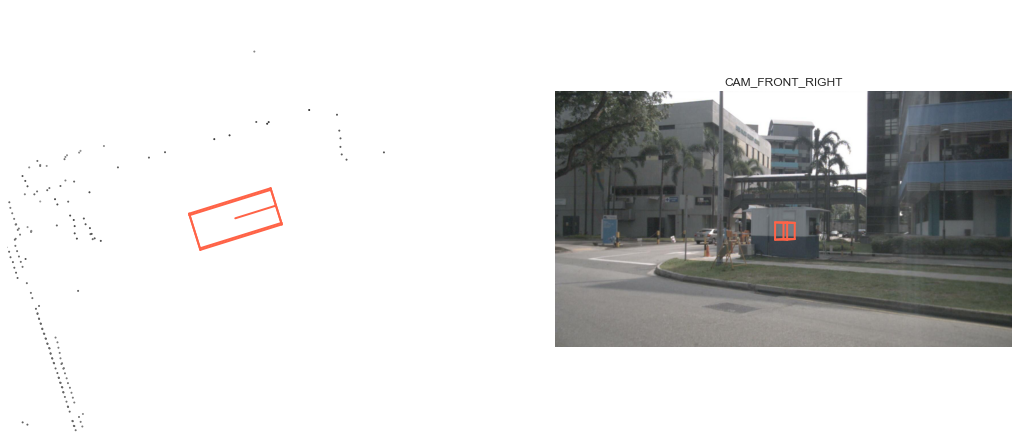

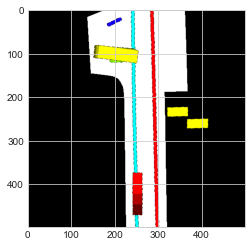

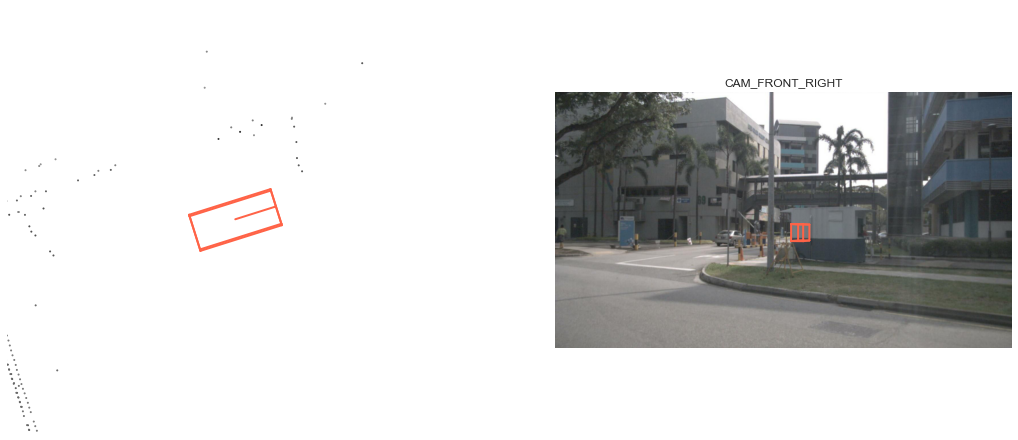

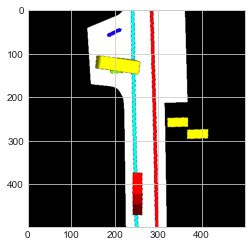

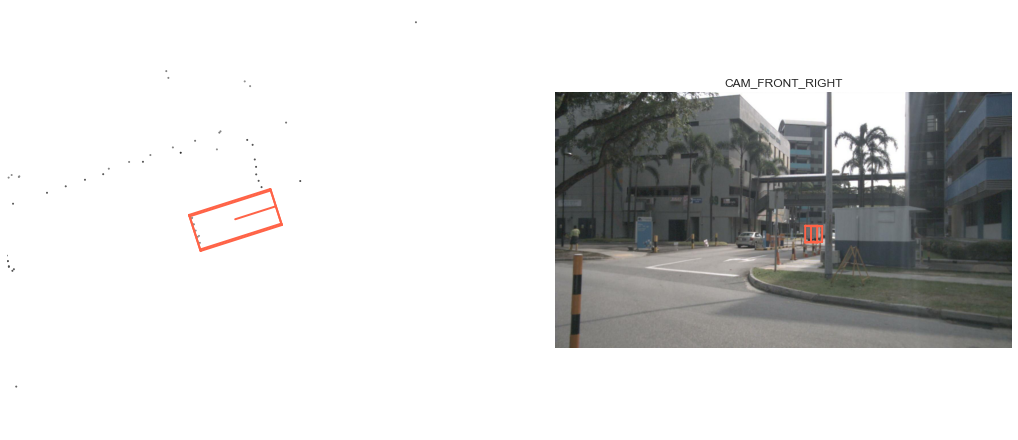

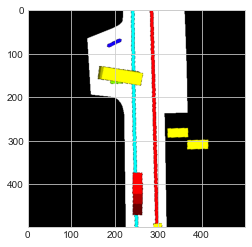

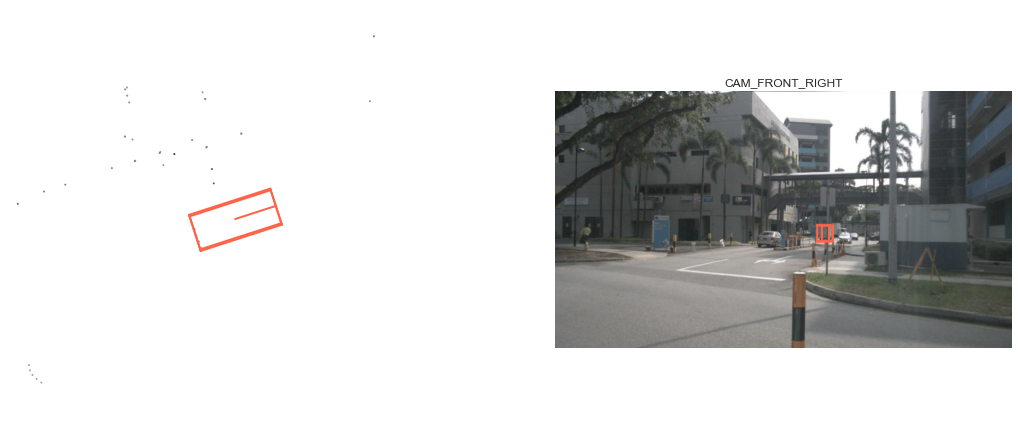

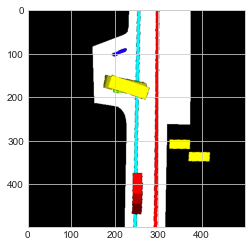

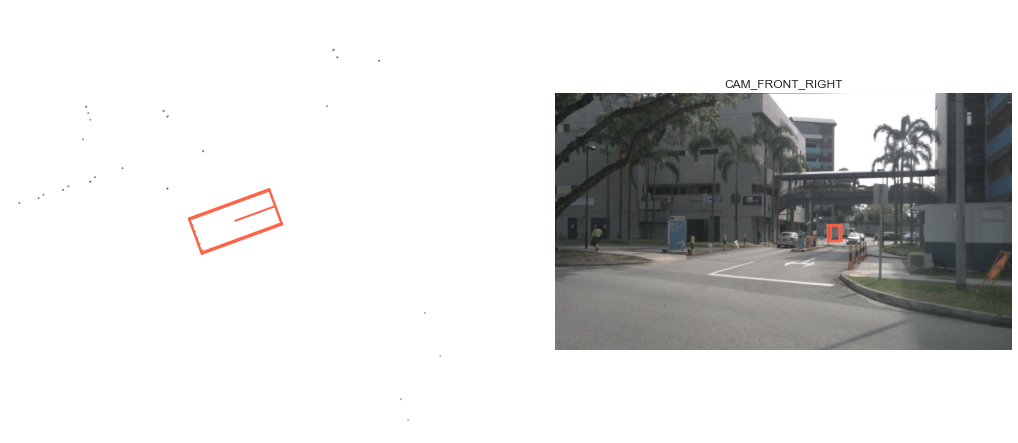

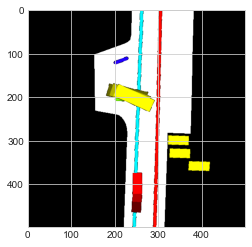

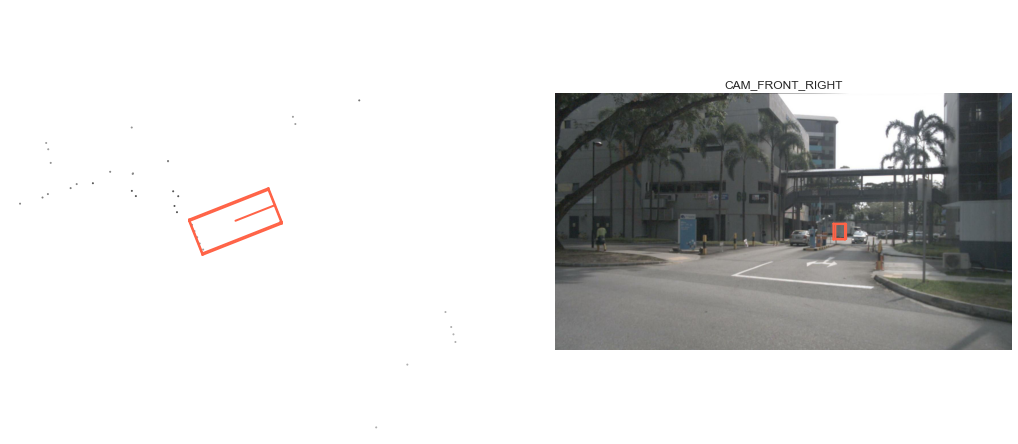

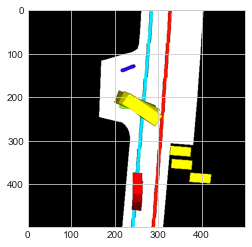

In [34]:
annotation = helper.get_sample_annotation(instance_token, sample_token)

render_future_for_agent(instance_token, sample_token, prediction_length)

In [16]:
# Meters / second.
print(f"Velocity: {helper.get_velocity_for_agent(instance_token, sample_token)}\n")
# Meters / second^2.
print(f"Acceleration: {helper.get_acceleration_for_agent(instance_token, sample_token)}\n")
# Radians / second.
print(f"Heading Change Rate: {helper.get_heading_change_rate_for_agent(instance_token, sample_token)}")

Velocity: 0.0388416806215895

Acceleration: -4.187883158947843e-06

Heading Change Rate: 0.0


#### Check BEV representation

In [28]:
import importlib
import custom_prediction.custom_input_representation.interface
import custom_prediction.custom_input_representation.agents
import custom_prediction.helper

importlib.reload(custom_prediction.custom_input_representation.interface)
importlib.reload(custom_prediction.custom_input_representation.agents)

<module 'custom_prediction.custom_input_representation.agents' from 'D:\\ThesisProjects\\Raster-traffic-motion-prediction\\custom_prediction\\custom_input_representation\\agents.py'>

In [18]:
import custom_prediction.helper
importlib.reload(custom_prediction.helper)

helper = PredictHelper(nusc)

In [19]:
from custom_prediction.custom_input_representation.static_layers import StaticLayerRasterizer
from custom_prediction.custom_input_representation.agents import AgentBoxesWithFadedHistory
from custom_prediction.custom_input_representation.interface import InputRepresentation
from custom_prediction.custom_input_representation.combinators import Rasterizer

# Input representation
def GenerateImage(instance_token, sample_token):
    static_layer_rasterizer = StaticLayerRasterizer(helper)
    agent_rasterizer = AgentBoxesWithFadedHistory(helper, seconds_of_history=1)

    mtp_input_representation = InputRepresentation(static_layer_rasterizer, agent_rasterizer, Rasterizer())

    img = mtp_input_representation.make_input_representation(instance_token, sample_token)

    return img


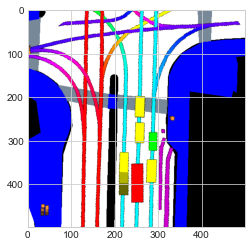

Get image in: 1.268; shape: (500, 500, 3)


In [20]:
import time

start_time = time.time()

img = GenerateImage(instance_token, sample_token)
plt.imshow(img)
plt.show()

print(f'Get image in: {round(time.time() - start_time, 3)}; shape: {img.shape}')

#### Check future path

In [130]:
future_xy_local = helper.get_future_for_agent(instance_token, sample_token, seconds=3, in_agent_frame=True)
future_xy_local

array([[ 0.03461636,  2.43531101],
       [ 0.06848134,  4.86996215],
       [ 0.1030977 ,  7.30527315],
       [ 0.11408296,  8.81882141],
       [ 0.12497671, 10.33095842],
       [ 0.13662184, 11.84375529]])

In [31]:
future_xy_global = helper.get_future_for_agent(instance_token, sample_token, seconds=3, in_agent_frame=False)
future_xy_global

array([[ 741.139, 1527.17 ],
       [ 742.946, 1525.538],
       [ 744.753, 1523.905],
       [ 745.883, 1522.898],
       [ 747.012, 1521.892],
       [ 748.141, 1520.885]])

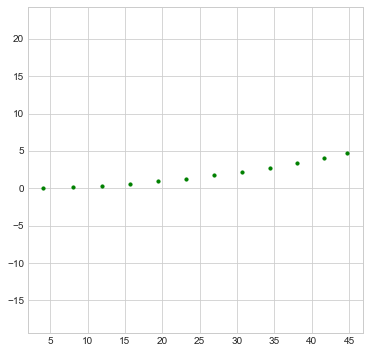

In [135]:
def PlotPathWithPrediction(future, predict=[]):
    plt.figure(figsize=(6, 6))

    plt.scatter(future[:, 1], -future[:, 0], c='g', s=10)
    
    if len(predict) > 0:
        plt.scatter(predict[:, 1], -predict[:, 0], c='yellow', s=10)

    # Keep aspect ratio of axis
    plt.axis('equal')
    plt.show()


gt = helper.get_future_for_agent(target_instance_token, start_prediction_sample_token, prediction_length, in_agent_frame=True)
    
PlotPathWithPrediction(gt)